# Download Google Images

In this notebook crawling google images for a combination of labels (classes) of the food-teuko and ranker dataset.  
Because crawling a lot of images for each random combination of food would take a long time and because the resulting images for very unusual combinations of food wont' be that useful, we first create a list of the most likely good multilabel foods by comparing them to a dataset containing >400k restaurant dishes.

#### Setup

In [0]:
!pip install google_images_download
from google.colab import drive
from google_images_download import google_images_download
from pathlib import Path
import pandas as pd
import os
from fastai.vision import verify_images
import requests
from bs4 import BeautifulSoup
from multiprocessing.pool import ThreadPool
import tqdm
from google.colab import auth

     |████████████████████████████████| 911kB 43.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/22/f3/7b/d1d7a18d9784458622ef3f9702c0bdbc179b431adde169c1a0
Successfully built google-images-download


mount gdrive


In [0]:

auth.authenticate_user()
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


input parameters

In [0]:

path = Path('data/')
teuko_fn = 'teuko_classes.txt'   #labels for Teuko
ranker_fn = 'ranker_classes.txt' #labels for Ranker
dish_fn = 'Dish.csv'             #menu dataset
down_path_single = path/'googleimg_single'  # Directory where single images will be downloaded
down_path_double = path/'googleimg_double'  # Directory where doube images will be downloaded
num_single = 100                 #number of images to download for each single lable
num_double = 100                 #number of images to download for each double lable
label_fname_single = 'googleimg_labels_single'
label_fname_double = 'googleimg_labels_double'
cutoff_total = 100
cutoff_ratio = 0.005

### Data Import
**Create directories and import data**

In [0]:
path.mkdir(parents=True, exist_ok=True)
down_path_single.mkdir(parents=True, exist_ok=True)
down_path_double.mkdir(parents=True, exist_ok=True)
! gsutil -m -q cp -r gs://platform-ai-research/datasets/food/{teuko_fn} {path}
! gsutil -m -q cp -r gs://platform-ai-research/datasets/food/{ranker_fn} {path}  
! gsutil -m -q cp -r gs://platform-ai-research/datasets/food/{dish_fn} {path}  

###Data Processing

**Create class lists**




classes are taken for google image search from the following sources:
*   teuko dataset (98 classes)
*  ranker dataset (388 classes)

A unique set of classes is then created with the lowercase version of the 2 datasets

In [0]:
teuko = list(pd.read_csv(path/teuko_fn, sep='\t', header = None)[0])
teuko_lower = [x.lower() for x in teuko]
ranker = list(pd.read_csv(path/ranker_fn,  sep='\t', header = None, encoding = 'latin1' )[0])
ranker_lower=[x.lower() for x in ranker]
teuko_lower[:5], ranker_lower[:5]

(['apple', 'apple slices', 'applesauce', 'asparagus', 'avocado dices'],
 ['chocolate chip cookies ',
  'cheesecake ',
  'bacon ',
  'spaghetti ',
  'cheeseburger '])

**Food product list for reference**

A list of >400k restaurant items collected by NYPL is used to determine the existence/popularity of the double label food for google image search

In [0]:
food_database = pd.read_csv(path/dish_fn, error_bad_lines = False, usecols=['name'])
food_list = food_database['name'].tolist()
food_list_unique=list(set(food_list))
food_list_lower = [x.lower().strip() for x in food_list_unique if type(x)==str]

Method to check for partial string matches in food product list

In [0]:
def countPartMatch(searchString1:str, searchlist:list, searchString2="") -> int:
  templist = [True for x in searchlist if searchString1 in x and searchString2 in x]
  count = len(templist)
  return count  

Loop through single classes to get base popularity in food list and reduce for double searchstrings if the food cannot be found


In [0]:
classes_single_total = list(set(teuko_lower + ranker_lower))    
single_results=[0]*len(classes_single_total)
single_results = [countPartMatch(searchstring, food_list_lower,) for searchstring in classes_single_total]
single_reduced_tp =[(x,single_results[y]) for y,x in enumerate(classes_single_total) if single_results[y] > 0]    

Create list for double classes for image search based on single_reduced_tp (around 40min runtime)


In [0]:
double_result_tmp = []
double_base = []
double_classes = []
double_perc= []

for count in tqdm.tqdm(range(len(single_reduced_tp))):
  if count < len(single_reduced_tp) -1:
    result_temp = [(countPartMatch(single_reduced_tp[count][0], food_list_lower,tup2[0]),single_reduced_tp[count][-1]+tup2[-1],
                    f'{single_reduced_tp[count][0]} and {tup2[0]}') for tup2 in single_reduced_tp[count+1:] if tup2[0] not in single_reduced_tp[count][0]
                   and single_reduced_tp[count][0] not in tup2[0]]
    double_result_tmp.append(result_temp)
  else:
    pass


100%|██████████| 372/372 [39:15<00:00,  6.33s/it]


Create dataframe with double classes, popularity and popularity as % of base

In [0]:
double_results_flat = [x for k in double_result_tmp for x in k]
double_results=[]
for x in double_results_flat:
  double_base.append(x[1])
  double_classes.append(x[-1])
  double_results.append(x[0])
  double_perc.append(x[0]/x[1])
result_table = pd.DataFrame(list(zip(double_classes, double_results,double_perc)),
                            columns=['double classes','double values', 'double % of base'])
result_table = result_table.sort_values(by=['double values','double % of base'], ascending=[False,False])
result_table = result_table.drop(result_table[(result_table['double % of base'] == 0)].index)



###Class selection
**Visualize results and select promising double label candidates**


best 20 combinations 

              double classes  double values  double % of base
63564      chicken and salad           1791          0.050619
23721       rice and chicken           1151          0.050676
47942          ham and salad           1093          0.030610
66264     salad and potatoes           1053          0.030862
47931       ham and sandwich            951          0.041163
47951           ham and eggs            930          0.038845
66193     bread and potatoes            854          0.035696
63578   chicken and potatoes            834          0.025920
30935        fruit and salad            828          0.033411
47956       ham and potatoes            806          0.024799
53617         toast and eggs            781          0.052774
45204   mayonnaise and salad            736          0.034809
47126   cranberry and turkey            730          0.164414
33628   cheese  and sandwich            729          0.073083
54266  mushrooms and chicken            722    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e4dddc5f8>]], dtype=object)

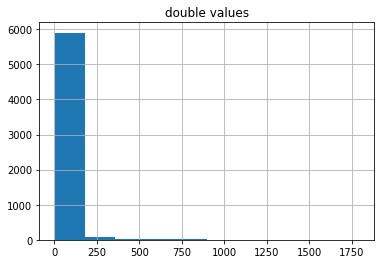

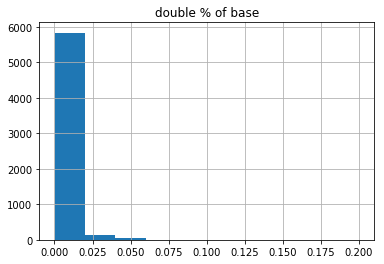

In [0]:
print('best 20 combinations \n')
print(result_table[:20])
print ('\nworst 20 combinations')
print(result_table[-20:])
result_table.hist(column ='double values', bins=10)
result_table.hist(column ='double % of base', bins=10)

**Filter double classes**

Double classes where the number of found dishes is too low will be dropped

In [0]:
result_table = result_table.drop(result_table[(result_table['double values'] < cutoff_total)].index)
result_table = result_table.drop(result_table[(result_table['double % of base'] < cutoff_ratio)].index)
classes_double_total = result_table['double classes'].tolist()

print('number of single classes: {}'.format(len(classes_single_total)))
print('number of double classes: {}'.format(len(classes_double_total)))
print(result_table)

number of single classes: 463
number of double classes: 256
                  double classes  double values  double % of base
63564          chicken and salad           1791          0.050619
23721           rice and chicken           1151          0.050676
47942              ham and salad           1093          0.030610
66264         salad and potatoes           1053          0.030862
47931           ham and sandwich            951          0.041163
47951               ham and eggs            930          0.038845
66193         bread and potatoes            854          0.035696
63578       chicken and potatoes            834          0.025920
30935            fruit and salad            828          0.033411
47956           ham and potatoes            806          0.024799
53617             toast and eggs            781          0.052774
45204       mayonnaise and salad            736          0.034809
47126       cranberry and turkey            730          0.164414
33628       chee

### Image download

In [0]:
def download_imgs(img_list, num=num_single, down_path=""):
    
    dfs = []

    response = google_images_download.googleimagesdownload()
    download_options = {'limit':num, 'format':'jpg', 'output_directory':str(down_path), 'no_directory':True,
                       'print_urls':False, 'print_paths':False, 'metadata':False, 'print_size':False}

    for i in range(len(img_list)):
        label = img_list[i]
        try:
            out = response.download({**download_options, **{'keywords':label}})
            temp_df = pd.DataFrame({'file':out[label]})
            temp_df['label'] = label
            dfs.append(temp_df)
        except:
            pass
    try:
       df = pd.concat(dfs, axis = 0)        
    except:
       df = pd.DataFrame({'file':[], 'label':[]})
         
    return df

single = classes_single_total
double = classes_double_total
  
#split data into chunks
chunks = 4
chunksize_single = int(len(single)/chunks)
chunksize_double = int(len(double)/chunks)

single_chunked = [single[i*chunksize_single:(i+1)*chunksize_single] for i in range(chunks)]
double_chunked = [double[i*chunksize_double:(i+1)*chunksize_double] for i in range(chunks)]



In [0]:
endpoint = chunks

for chunk in range(endpoint):
  down_path_single_temp = str(down_path_single) + "_" + str(chunk)
  down_path_double_temp = str(down_path_double) + "_" + str(chunk)
  single_temp = single_chunked[chunk]
  double_temp = double_chunked[chunk]
  label_fname_single_temp = label_fname_single + "_" + str(chunk) + ".csv"
  label_fname_double_temp = label_fname_double + "_" + str(chunk) + ".csv"
  if num_single != 0:
      single_data = download_imgs(single_temp, num=num_single, down_path=down_path_single_temp)
      single_data['label'] = single_data['label'].apply(lambda x: x.replace(' ', '_'))
  else:
      single_data = pd.DataFrame({'file':[], 'label':[]})

  if num_double != 0:
      double_data = download_imgs(double_temp, num = num_double, down_path=down_path_double_temp)
      double_data['label'] = double_data['label'].apply(lambda x: x.replace(' and ', '**').replace(' ', '_').replace('**', ' '))
  else:
      double_data = pd.DataFrame({'file':[], 'label':[]})

  verify_images(down_path_single_temp, delete=True, max_size = 500)
  verify_images(down_path_double_temp, delete=True, max_size = 500)

  # Only keep the last part of the file extension
  single_data['file'] = single_data['file'].apply(lambda x: str(x).split('/')[-1])
  double_data['file'] = double_data['file'].apply(lambda x: str(x).split('/')[-1])

  # Only keep labels that correspond to files (we deleted some images)
  single_data = single_data[single_data['file'].isin(os.listdir(down_path_single_temp))]
  double_data = double_data[double_data['file'].isin(os.listdir(down_path_double_temp))]

  #dump data
  single_data.to_csv(path/label_fname_single_temp, index=False, header=True)
  double_data.to_csv(path/label_fname_double_temp, index=False, header=True)

